In [4]:
import os
import pickle
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from skimage.io import imread
from random import shuffle

def get_image_paths(data_path, categories, num_train_per_cat=62, fmt='png'):
    """
    This function returns lists containing the file path for each train
    and test image, as well as listss with the label of each train and
    test image. By default all four of these arrays will have 22
    elements where each element is a string.
    :param data_path: path to the 'test' and 'train' directories
    :param categories: list of category names
    :param num_train_per_cat: max number of training images to use (per category)
    :param fmt: file extension of the images
    :return: lists: train_image_paths, test_image_paths, train_labels, test_labels
    """
    train_image_paths = []
    test_image_paths = []
    train_labels = []
    test_labels = []

    for cat in categories:
        # train
        pth = os.path.join(data_path, 'ic_chips_train', cat, '*.{:s}'.format(fmt))
        pth = glob(pth)
        shuffle(pth)
        pth = pth[:num_train_per_cat]
        train_image_paths.extend(pth)
        train_labels.extend([cat]*len(pth))

        # test
        pth = os.path.join(data_path, 'ic_chips_test', cat, '*.{:s}'.format(fmt))
        pth = glob(pth)
        shuffle(pth)
        pth = pth[:num_train_per_cat]
        test_image_paths.extend(pth)
        test_labels.extend([cat]*len(pth))

    return train_image_paths, test_image_paths, train_labels, test_labels

def show_results(train_image_paths, test_image_paths, train_labels, test_labels,
    categories, abbr_categories, predicted_categories):
    """
    shows the results
    :param train_image_paths:
    :param test_image_paths:
    :param train_labels:
    :param test_labels:
    :param categories:
    :param abbr_categories:
    :param predicted_categories:
    :return:
    """
    cat2idx = {cat: idx for idx, cat in enumerate(categories)}

    # confusion matrix
    y_true = [cat2idx[cat] for cat in test_labels]
    y_pred = [cat2idx[cat] for cat in predicted_categories]
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float64') / cm.sum(axis=1)[:, np.newaxis]
    acc = np.mean(np.diag(cm))
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('jet'))
    plt.title('Confusion matrix. Mean of diagonal = {:4.2f}%'.format(acc*100))
    tick_marks = np.arange(len(categories))
    plt.tight_layout()
    plt.xticks(tick_marks, abbr_categories, rotation=45)
    plt.yticks(tick_marks, categories)

In [5]:
# Set up parameters, image paths and category list

# This is the list of categories / directories to use. The categories are
# somewhat sorted by similarity so that the confusion matrix looks more
# structured (indoor and then urban and then rural).
categories = ['16pins', 'not_small_pins', 'small_pins'];

# This list of shortened category names is used later for visualization
abbr_categories = ['16pins', 'not_small_pins', 'small_pins'];

# Number of training examples per category to use. Max is 100. For
# simplicity, we assume this is the number of test cases per category, as
# well.
num_train_per_cat = 62

# This function returns lists containing the file path for each train
# and test image, as well as lists with the label of each train and
# test image. By default all four of these lists will have 1500 elements
# where each element is a string.

datapath = 'C:/Users/ASUS/Desktop/ic_chips_images/ic_chips + features + recognition/ic_chips/' 
data_path = os.path.join(datapath, 'dataset')
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path,
                                                                                 categories,
                                                                                 num_train_per_cat)

In [6]:
from skimage.transform import resize


def get_tiny_images(image_paths):
    """
    To build a tiny image feature, simply resize the original image to a very
    small square resolution, e.g. 16x16. You can either resize the images to
    square while ignoring their aspect ratio or you can crop the center
    square portion out of each image. Making the tiny images zero mean and
    unit length (normalizing them) will increase performance modestly.

    Args:
    -   image_paths: list of N elements containing image paths

    Returns:
    -   features: N x d numpy array of resized and then vectorized tiny images
            e.g. if the images are resized to 16x16, d would be 256
    """

    features = []

    for image_name in image_paths:
        image = imread(image_name)
        resized = resize(image, output_shape=(32, 32)).flatten()
        features.append(resized)
        
    features = np.vstack(features)
    features = features - np.mean(features, axis=0)
    features = features / np.std(features, axis=0)

    return features

train_image_feats = get_tiny_images(train_image_paths)
test_image_feats = get_tiny_images(test_image_paths)
print(train_image_feats.shape)
print(test_image_feats.shape)

(62, 4096)
(10, 4096)


In [7]:
from sklearn.neighbors import KNeighborsClassifier


def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats,
    metric='euclidean'):
    """
    This function will predict the category for every test image by finding
    the training image with most similar features. Instead of 1 nearest
    neighbor, you can vote based on k nearest neighbors which will increase
    performance (although you need to pick a reasonable value for k).

    Args:
    -   train_image_feats:  N x d numpy array, where d is the dimensionality of
          the feature representation
    -   train_labels: N element list, where each entry is a string indicating
          the ground truth category for each training image
    -   test_image_feats: M x d numpy array, where d is the dimensionality of the
          feature representation. You can assume N = M, unless you have changed
          the starter code
    -   metric: (optional) metric to be used for nearest neighbor.
          Can be used to select different distance functions. The default
          metric, 'euclidean' is fine for tiny images. 'chi2' tends to work
          well for histograms

    Returns:
    -   test_labels: M element list, where each entry is a string indicating the
          predicted category for each testing image
    """

    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(train_image_feats, train_labels)
    test_labels = clf.predict(test_image_feats)

    return test_labels

predicted_categories = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)
print(predicted_categories)

['16pins' '16pins' '16pins' '16pins' 'not_small_pins' 'not_small_pins'
 'small_pins' '16pins' '16pins' 'small_pins']


c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12460\1011149599.py:67: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float64') / cm.sum(axis=1)[:, np.newaxis]


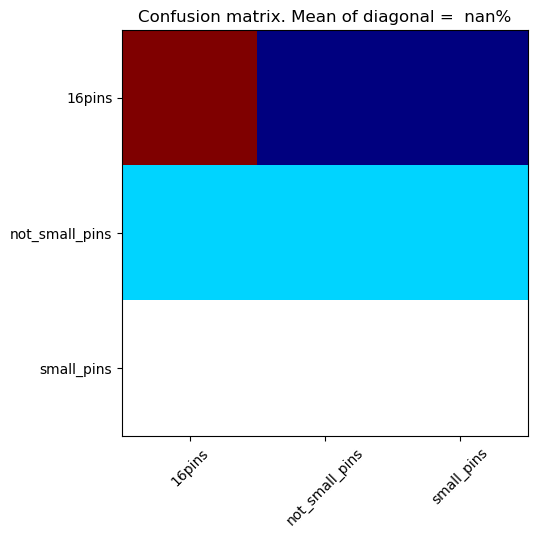

In [8]:
show_results(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories,
             predicted_categories)

In [9]:
from cv2 import SIFT_create
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances

# initialise SIFT object
sift = SIFT_create()

def build_vocabulary(image_paths, vocab_size):
    """
    This function will sample SIFT descriptors from the training images,
    cluster them with kmeans, and then return the cluster centers.

    Args:
    -   image_paths: list of image paths.
    -   vocab_size: size of vocabulary (cluster centers)

    Returns:
    -   vocab: This is a vocab_size x d numpy array (vocabulary). Each row is a
      cluster center / visual word
    """

    dim = 128         # length of the SIFT descriptors that you are going to compute.
    vocab_size = 20  # the number of cluster centers

    # extract features
    features = []
    keypoints = []

    for img_path in train_image_paths:

        img = imread(img_path)
        keys, descriptors = sift.detectAndCompute(img, None)
        features.append(descriptors) #np.vstack([features, descriptors])
        keypoints.append(keys)

    all_features = np.vstack(features)

    # cluster features
    kmeans = MiniBatchKMeans(n_clusters=vocab_size)
    kmeans.fit(all_features)

    vocab = kmeans.cluster_centers_

    return vocab, keypoints

def get_bags_of_sifts(image_paths, vocab_filename):
    """
    You will want to construct SIFT features here in the same way you
    did in build_vocabulary() and then assign each local feature to its nearest
    cluster center and build a histogram indicating how many times each cluster was used.
    Don't forget to normalize the histogram, or else a larger image with more
    SIFT features will look very different from a smaller version of the same
    image.

    Args:
    -   image_paths: paths to N images
    -   vocab_filename: Path to the precomputed vocabulary.
          This function assumes that vocab_filename exists and contains an
          vocab_size x 128 ndarray 'vocab' where each row is a kmeans centroid
          or visual word. This ndarray is saved to disk rather than passed in
          as a parameter to avoid recomputing the vocabulary every run.

    Returns:
    -   features: N x d matrix, where d is the dimensionality of the
          feature representation. In this case, d will equal the number of
          clusters or equivalently the number of entries in each image's
          histogram (vocab_size) below.
    """

    # load vocabulary
    with open(vocab_filename, 'rb') as f:
        vocab = pickle.load(f)
    
    features = []

    for img_path in image_paths:

        img = imread(img_path)
        _, descriptors = sift.detectAndCompute(img, None)

        dists = pairwise_distances(vocab, descriptors)

        argmin = np.argmin(dists, 0)
        hist = np.bincount(argmin, minlength=20)
        hist = hist / hist.sum()

        features.append(hist)

    return np.vstack(features)

vocab_filename = 'vocab.pkl'

if not os.path.isfile(vocab_filename):
    # Construct the vocabulary
    print('No existing visual word vocabulary found. Computing one from training images')
    vocab_size = 200  #zLarger values will work better (to a point) but be slower to compute
    vocab, keypoints = build_vocabulary(train_image_paths, vocab_size)
    with open(vocab_filename, 'wb') as f:
        pickle.dump(vocab, f)
        print('{:s} saved'.format(vocab_filename))

train_image_feats = get_bags_of_sifts(train_image_paths, vocab_filename)
test_image_feats = get_bags_of_sifts(test_image_paths, vocab_filename)

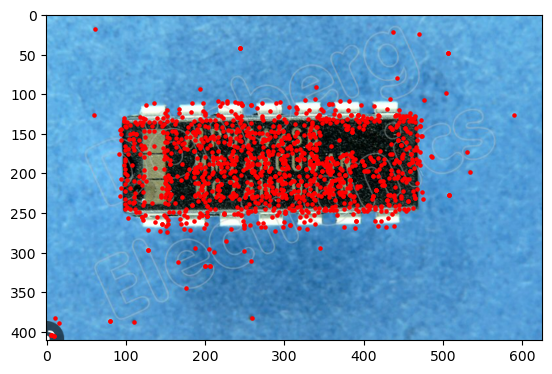

In [10]:
img = imread(train_image_paths[0])
keypoints, descriptors = sift.detectAndCompute(img, None)

fig, ax = plt.subplots()

ax.imshow(img)

for k in keypoints:
    x, y = k.pt
    plt.scatter(x, y, color='red', s=5)

In [11]:
predicted_categories = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)

c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


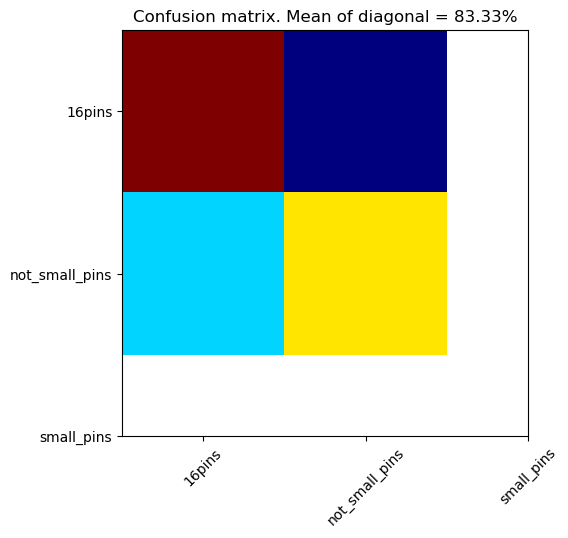

In [12]:
show_results(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories,
             predicted_categories)

In [13]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC


def svm_classify(train_image_feats, train_labels, test_image_feats):
    """
    This function will train a linear SVM for every category (i.e. one vs all)
    and then use the learned linear classifiers to predict the category of
    every test image. Every test feature will be evaluated with all 15 SVMs
    and the most confident SVM will "win". Confidence, or distance from the
    margin, is W*X + B where '*' is the inner product or dot product and W and
    B are the learned hyperplane parameters.

    Args:
    -   train_image_feats:  N x d numpy array, where d is the dimensionality of
          the feature representation
    -   train_labels: N element list, where each entry is a string indicating the
          ground truth category for each training image
    -   test_image_feats: M x d numpy array, where d is the dimensionality of the
          feature representation. You can assume N = M, unless you have changed
          the starter code
    Returns:
    -   test_labels: M element list, where each entry is a string indicating the
          predicted category for each testing image
    """

    clf = OneVsRestClassifier(SVC(random_state=0, tol=1e-3, C=5))
    clf.fit(train_image_feats, train_labels)

    test_labels = clf.predict(test_image_feats)

    return test_labels

predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12460\1011149599.py:67: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float64') / cm.sum(axis=1)[:, np.newaxis]


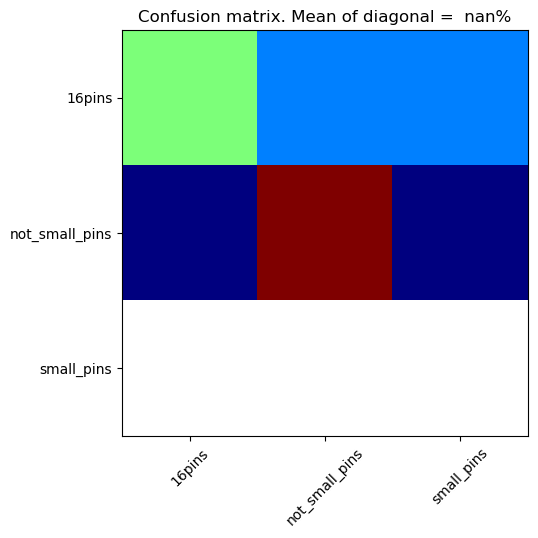

In [14]:
show_results(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories,
             predicted_categories)